## Predicting Insurance Claims for Porto Seguro

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

**Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies**, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

<img src = "./supp/empresas-do-grupo.jpg" >

_____

### Breaking it down...

Basically, PS (Porta Seguro) wants to calculate their budgeting using a scientific backbone, primarily through the use of machine learning! It's simple, if they know how many insurance claims will be made for each driver, they'll get an estimate on how much they'll need to pay out. Knowing this, they can up the predmiums for the bad drivers, and lower the premium for the good, essentially leveling out the costs associated in the coming year. Doing this, they are maximizing the probabilty that good drivers will respond positively to the premium changes, which in turn obviously helps the company stay in business.

Let's start by preprocessing the data and getting it prepped for training.

### Preprocess data

Note the Label Name System:

Types - ind, reg, car, calc
BIN - binaray
CAT - categorical
NONE - cont or ordinal
Target - POS class = filed claim
VALUES of '-1' indicate missing


Let's beging by importing our dependencies, and then reading in train and test sets.

In [1]:
# Import the good stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from adspy_shared_utilities import plot_labelled_scatter, plot_feature_importances

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import time

In [2]:
sns.set(style="whitegrid", color_codes=True)
# Read in data
def ReadData():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    return train, test

# NaN majority check
def MajorityNaN(df, plot = True, threshold = 0.6, max_cols=5):
    
    '''Create boolean array of majority NaN features and return non-NaN majority dataframe'''
    
    percentage_NaN = (df.isnull().sum() / len(df)) # Get percentages of NaNs per feature
    
    ''' Plot the features with NaN percentage '''
    if plot:
        percentage_NaN.sort_values(ascending=False, inplace=True)
        plt.figure(figsize=(10,10))
        d = {True: 'Above threshold', False: 'below threshold'}
        hue = (percentage_NaN >= threshold).apply(lambda x: d[x])
        sns.barplot(y = percentage_NaN.index.values[0:max_cols], x = percentage_NaN.loc[percentage_NaN.index][0:max_cols], hue = hue[0:max_cols])
        plt.title('Prevalence of NaNs')
        plt.xlabel('Percent NaN')
        plt.ylabel('Feature')
        plt.legend(loc='upper right')
        plt.xlim(0,1)
        plt.show()
    
    ''' Return dataframe of features without majority NaNs'''
    this =  percentage_NaN <= threshold # convert to boolean array
    df = df.loc[:, this] # update df
    return df

In [3]:
# Read in data
df_train, df_test = ReadData()

In [4]:
print('Shape of Train df: {}'.format(df_train.shape))
print('Shape of Test df: {}'.format(df_test.shape))

Shape of Train df: (595212, 59)
Shape of Test df: (892816, 58)


Let's drop features that we absoultely do not need for analysis. This would simply include features that have a self-defined ratio of NaNs to n_samples. Note that we do not actually have NaNs in this dataset, but rather '-1'. This doesn't appear to hold signifiance, and given the natural abstraction and no domain knowledge of this data set, we can just replace with NaN. We will remove features that meet the threshold criteria - we'll then impute everything else based on the feature type (continuous or categorical).

To note, we'd also like to remove features during this step that may appear redundant, but the column names provided are purposefully abstract. We can remove features later, however, once we've finished with some manual preprocessing by using a meta transformer such as SelectFromModel. Feature selection/removal for this data set is extremely important, as the size of the data is quite large.

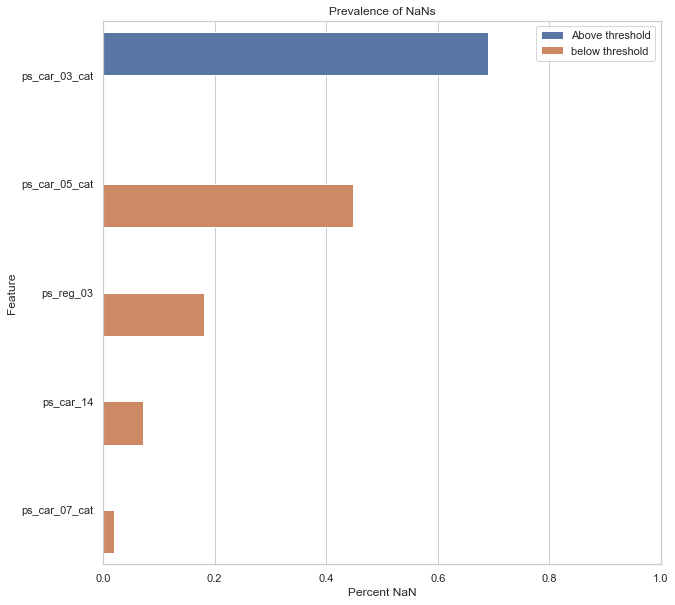

In [5]:
# First, replace -1 with np.NaN
df_train.replace(-1, np.nan, inplace = True)
df_test.replace(-1, np.nan, inplace = True)

# Then, check and drop NaNs with our function
df_train = MajorityNaN(df_train)
df_test = MajorityNaN(df_test, plot = False)

In [6]:
print('Shape of Train df: {}'.format(df_train.shape))
print('Shape of Test df: {}'.format(df_test.shape))

Shape of Train df: (595212, 58)
Shape of Test df: (892816, 57)


Next, we'll fill the NaN's with both the mean and frequency of the respected feature. Alternatively, we could impute the data with some of the built in modules from Sci-kit learn, but we'll manually add these in ourselves.

Afterwards, we'll one-hot-encode with a self-defined function to remove the categorical data and replace them with binary codes. A frequency threshold is set that dumps categories that are below this threshold into an 'unknown' category. We'll also ensure that the number of categories remains consistent with our test set.

In [7]:
# Let's first write a function to call each feature by its respected 'type'. 
# This will make it easier to fill nan's and one-hot-encode.

# Requires input dataframe and labeltype ['cat', 'bin', or 'other']
def GetFeatures(df, labelType):
    if labelType == 'other':
        label_type_bool = (~df.columns.str.contains('cat')) & (~df.columns.str.contains('bin'))
        features = df.columns[label_type_bool]
    else:
        label_type_bool = df.columns.str.contains(labelType)
        features = df.columns[label_type_bool]
        
    return features.tolist()

features_type = GetFeatures(df_train, 'cat')

# Fill NaN's
def fillNa(df):
    # other (not cat or bin) replaced with mean
    features_type = GetFeatures(df, 'other')
    df[features_type] = df[features_type].fillna(df[features_type].mean())
    
    # cat replaced with most frequent per feature
    features_type = GetFeatures(df, 'cat')
    for feature in features_type:
        df[feature] = df[feature].fillna(df[feature].value_counts().index[0])

    return df

df_train = fillNa(df_train)
df_test = fillNa(df_test)


def OneHotEncode(train, test, features):
    threshold = 100 # frequency of categories
    unknown_cat = '<unknown>' # name of additional 'unknown' category
    
    for feature in features:
        # Get count and cats to keep from train (so it matches test)
        count = train[feature].value_counts()
        categories_to_keep = count[count > threshold].index.tolist()  
         
        # Set each feature as cats with cats to keep above
        train[feature] = pd.Categorical(train[feature], 
                categories = categories_to_keep, ordered=True)
        
        if unknown_cat in categories_to_keep:
            categories_to_keep.remove(unknown_cat)
        test[feature] = pd.Categorical(test[feature], 
                categories = categories_to_keep, ordered=True)
        
        # Add unknown cat based on train features, then just fill in na's for both
        train[feature] = train[feature].cat.add_categories(unknown_cat).fillna(unknown_cat) 
        test[feature] = test[feature].cat.add_categories(unknown_cat).fillna(unknown_cat)
        
    # get_dummies
    train = pd.get_dummies(train, columns = features)
    test = pd.get_dummies(test, columns = features)
    
    return train, test

df_train_og, df_test_og = df_train.copy(), df_test.copy()
df_train, df_test = OneHotEncode(df_train, df_test, features_type)

In [8]:
print('Shape of Train_Encode df: {}'.format(df_train.shape))
print('Shape of Test_Encode df: {}'.format(df_test.shape))

Shape of Train_Encode df: (595212, 231)
Shape of Test_Encode df: (892816, 230)


### Class Imbalance

Let's calculate the class target ratios to observe any imbalance among the classes.

In [9]:
df_train.target.value_counts() / df_train.shape[0]

0    0.963552
1    0.036448
Name: target, dtype: float64

This dataset is highly imbalanced - we're going to be highly biased towards the negative (0) class. We can attenuate this bias by oversampling (which is replicating samples of the minority class; the positive class) by performing a method known as SMOTE (Synthetic Minority Oversampling TEchnique). Note that this method does not work on datasets with high dimensionality. In our case, we have much more samples than attributes, so SMOTE should work well here. Learn more about SMOTE here: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

This oversampling method will be applied automatically in the Pycaret section near the bottom of this notebook.

### Train the Model

We can now train the model with any classifer, as we have successfully encoded all the categorical data. Note that we could have left the categorical data untouched, but that would limit us to using specific classifiers like decision trees to train our model, which can be expensive given the data size. It's best we start simple with a low-level classifier to get quick results. From there, we can expand to more complex models if we believe the time and effort is worth the improvement in score.

Let's define some helpful functions for us as we begin to train the model.

In [9]:
# GridSearch function
def runGridCV(alg, train, param_grid, features):
    print('Running gridsearchcv...')
    cv = StratifiedKFold(n_splits = 5, random_state = 0)
    gsearch = GridSearchCV(alg, param_grid = param_grid, 
                            scoring='roc_auc', cv = cv)
    gsearch.fit(train[features],train[target])
    print('Done!')
    return gsearch

# CV: Time Series or group wise? 
#http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-i-i-d-data
def runCV(alg, train, scoring, cv, features):
    print('Running CV...')
    scores = cross_validate(alg, train[features], train[target], 
                            scoring=scoring, cv = cv, return_train_score=True, n_jobs=-1)
    print('Done!')
    return scores
    
# If train/validation metrics look okay, proceed with test proba                  
def runTest(train, test, estimator):
    estimator.fit(train[predictors], train[target])
    y_prob = estimator.predict_proba(test[predictors])[:,1]
    df = pd.DataFrame(y_prob, columns=['target']).join(test[ID]).set_index('id')
    df.to_csv('submit.csv')
    
#Generate a simple plot of the test and training learning curve.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring = 'roc_auc',
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    print("Plotting learning curve...")

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("roc_auc Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring, random_state=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    print("Done!")
    return plt



#### Logistic Regression

We can start with a simple yet powerful logistic regression classifier. Note that we'll have to transform the data in order to use logistic regresion. Not transforming the data will add weight to other features that may not actually hold more significance over another. For this, we'll use pipelining. 

Let's define our 'predictors', 'target' and 'id' column just to cherry-pick these out quickly.

In [10]:
ID = 'id'
target = 'target'
predictors = [x for x in df_train.columns if x not in [ID, target]]
predictors_og = [x for x in df_train_og.columns if x not in [ID, target]]

Let's run our first classifier and see the result on our train and validation set (5 folds). Note that we will score this with roc_auc as we care about maximizing TP and reducing FP. A simple accuracy score will not suffice.

In [43]:
# Run CV
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)
estimator = LogisticRegression(C = 1.0)
clf = make_pipeline(StandardScaler(), estimator)

In [44]:
ts = time.time()
scores = runCV(clf, df_train, 'roc_auc', cv, predictors)
time.time() - ts

Running CV...
Done!


23.94648313522339

In [45]:
scores

{'fit_time': array([20.09824181, 18.2561686 , 19.73820448, 19.21759748, 18.22525072]),
 'score_time': array([0.52260208, 0.52260494, 0.5226016 , 0.46076822, 0.53955817]),
 'test_score': array([0.63187006, 0.6165425 , 0.62229801, 0.63721094, 0.6236939 ]),
 'train_score': array([0.63136362, 0.63478384, 0.63369048, 0.63008811, 0.6337227 ])}

In [46]:
scores['train_score'].mean()

0.6327297487128482

In [47]:
scores['test_score'].mean()

0.6263230792835623

We can note above that our train and test scores are pretty close, and actually quite low. This is clearly a biased model, and thus needs more complexity. Let's try increasing our C parameter (inverse of our regularization constant, lambda) over a gridsearch.

In [50]:
ts = time.time()

estimator = LogisticRegression()

# Call GridSearch function
pipe = Pipeline(steps = [('scaler', StandardScaler()), ('logistic', estimator)])

# Prediction
C = np.arange(1, 11, 1).tolist()

# Parameters of pipelines can be set using ‘__’ separated parameter names:
clf_g_1 = GridSearchCV(pipe, dict(logistic__C = C), scoring='roc_auc', cv = cv)
clf_g_1.fit(df_train[predictors],df_train[target])

clf_g_1.best_score_, clf_g_1.best_params_ 

time.time() - ts

411.95907735824585

In [51]:
clf_g_1.best_score_, clf_g_1.best_params_ 

(0.6263230796854138, {'logistic__C': 1})

From the above test score, we can see that the score doesn't change much at all from the baseline model because C stays at 1. We can conclude that Logistic Regression is probably too simple of a model, and that there is some bias (underfitting) going on that we cannot fix by simply tuning the parameters. Let's plot a learning curve of the train / validation set and confirm our suspicion. 

We'll use a cv value of 2 to improve the time, as there is really no point in running 5 folds for such an early estimte of our model.

Plotting learning curve...


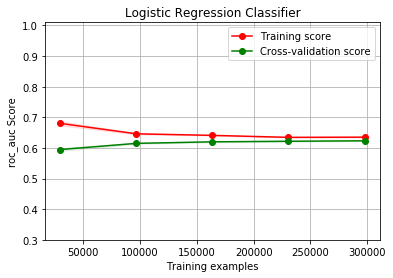

In [45]:
title = "Logistic Regression Classifier"
plot_learning_curve(estimator, title, df_train[predictors], df_train[target], 
                   ylim = (0.3, 1.01), cv = 2)
plt.show()

As we predicted, this model is severaly underfitting the data. The training score and validation score converge at about 240,000 samples (or a total of 480,000 samples).

So, we know we'll need a more robust model to tackle this data set. *However, a more robust is not gaurenteed to fix our underlying high bias issue* - we may need to **engineer new features** to add variance into this dataset.

### Gradient Boosted Decision Trees

We can use a more robust model, namely a Gradient Boosted Decision Tree (GBDT), to train our model. This classifier is a great 'off-the-shelf' solution for many problems with high dimensionality, and continuous, categorical and binary data. With that, let's use our training set without the one-hot-encoded features (predictors_og), and produce the results. 

Note: With GBDT, there is no need to normalize/scale the data, thus we will not run a pipline with the estimator and scaler functions.

In [11]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)
clf_GBC = GradientBoostingClassifier()

In [53]:
ts = time.time()
scores = runCV(clf_GBC, df_train_og, 'roc_auc', cv, predictors_og)
time.time() - ts

Running CV...
Done!


206.6878378391266

In [54]:
print("Train score: {}. Test score: {}".format(scores['train_score'].mean(), scores['test_score'].mean()))

Train score: 0.6486630493539667. Test score: 0.6372317861115641


We can see that the train/test scores from GBDT out-perform the scores from the logistic regression model. However, the model is still highly biased. 

### XGBoost

In [12]:
from xgboost import XGBClassifier

In [18]:
ts = time.time()

xgbmodel = XGBClassifier(
    max_depth=7,
    n_estimators=500,
    seed=42,
   # tree_method='gpu_hist',
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    n_jobs=-1)

scores = runCV(xgbmodel, df_train_og, 'roc_auc', cv, predictors_og)
time.time() - ts

Running CV...
Done!


874.9739499092102

In [19]:
print("Train score: {}. Test score: {}".format(scores['train_score'].mean(), scores['test_score'].mean()))

Train score: 0.9919794794101164. Test score: 0.563585604283998


This model's train scores are improving! Meaning, our model is fitting the data better than the standard GBDT. However we are now severaly overfitting - we can imrove the validation score by tuning the parameters over grid search. Since this dataset is quite complex with almost 1M rows and 50+ attributes, we won't show the actual results due to computational resources. 

The code below is how you'd do it (with max_depth as an example):

In [13]:
ts = time.time()

parameters = {'max_depth':[10, 50, 100]}

xgbmodel = XGBClassifier(
    max_depth=7,
    n_estimators=50,
    seed=42,
   # tree_method='gpu_hist',
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    n_jobs=-1)

clf_xgb_1 = GridSearchCV(xgbmodel, param_grid=parameters, cv=cv, verbose=1,
                        scoring='roc_auc', return_train_score=True, n_jobs =-1)

clf_xgb_1.fit(df_train_og[predictors_og], df_train_og[target])

time.time() - ts

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 15.2min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 17.0min finished


1045.7356810569763

We can correct the underfitting by engineering new features, but the feature names are inherently abstract (this was Porto Seguro's intention) and thus we cannot engineer by just using off feature names. 

Another approach is to find the most important features (important meaning a feature that holds the most weight in predicting correctly) and then engineer features basesd on those features. We can plot the feature importances from GBDT, as shown below:

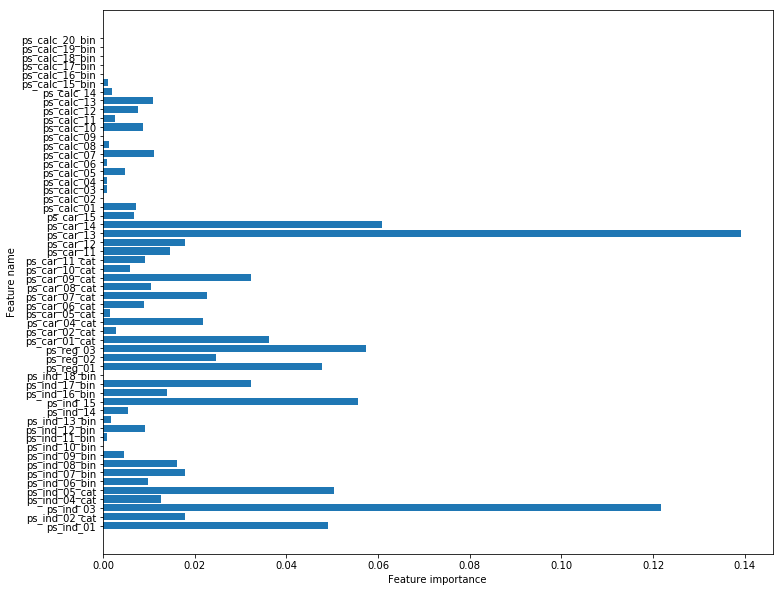

In [45]:
plt.figure(figsize=(12, 10))
plot_feature_importances(clf_GBC, predictors_og)
plt.show()

From the plot above, we can hand-pick the two largest contributers:

    'ps_car_13'
    'ps_ind_03'

We could now perform some type of engineering on these features, like creating polynomial features of degree 'n' or performing some operation between the two, though we'd be careful to not add redundant data. 

We could plot these two features against the target value, but let's take a peek at the unique values of the feature 'ps_ind_03'.


In [78]:
df_train_og.ps_ind_03.unique()

array([ 5,  7,  9,  2,  0,  4,  3,  1, 11,  6,  8, 10], dtype=int64)

This looks a **lot like categorical data, and not continuous** (as it was defined). A scatter plot will be pretty meaningless here. Let's look at a violin plot of the two features. 

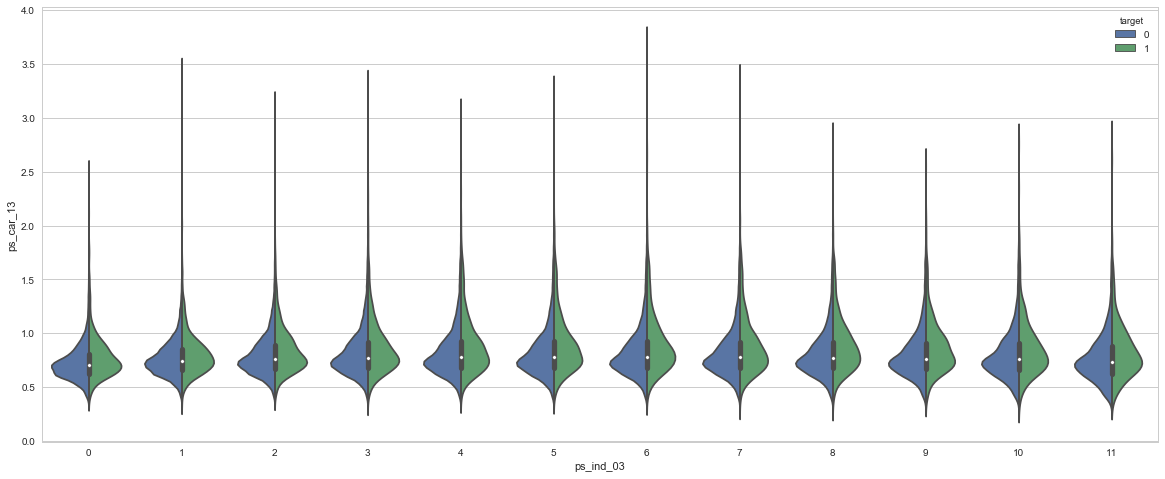

In [77]:
plt.figure(figsize=(20,8))
sns.violinplot(x="ps_ind_03", y="ps_car_13", hue="target", data=df_train_og, split=True)
plt.show()

Looking at this violin plot, we can see how the categorical data is distributed across the opposing continous feature, with a 'hue' of the target value. It appears that the target value is pretty well distributed across all the categories. We expected that there would be more representation of the negative class (0), as the data is quite skewed (approx. 4% positive). 

Outliers between these two features is pretty standard, with the majority of categories found within 0.5 and 1.0 of ps_car_13.

## Feature Engineering

Let's try Pycaret's compare_models function to get us the best model to use for our current data set. It will even engineer features, and tune our best model. You can read more here: https://github.com/pycaret/pycaret/blob/master/examples/PyCaret%202%20Classification.ipynb

### Pycaret

We'll initiate our model here, and call out a few things:

1. Normalize = True: We want to normalize our data so linear classifiers can work well here, too. We saw beforehand that a simple Logistic Regression model was performing on par to a GBDT for this set.
2. Remove outliers = True: We want to remove any outliers to prevent our model from learning from a distribution that might not look quite the same in unseen data.
3. Poly and Trig feataures = True: Let's engineer some new features using these methods.
4. Fix imbalance (SMOTE) = True: We mentioned ealier that this data set suffers from severe bias towards the negative class. Let's adjust with sample replication of the minority class so we can hopefully attenuate to overfitting.

In [12]:
from pycaret.classification import *
clf1 = setup(df_train_og, target = 'target', session_id=123, log_experiment=False, experiment_name='porto_1',
            normalize=True,remove_outliers=True, polynomial_features=True, trigonometry_features=True, fix_imbalance=True)

In [12]:
model_list = ['lr', 'ridge', 'rf', 'gbc', 'et', 'xgboost', 'lightgbm', 'catboost']

#### Compare Baseline 

In [13]:
best_model = compare_models(whitelist = model_list, fold=3, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.9643,0.6269,0.0000,0.0000,0.0000,0.0000,0.0000,12.1477
1,Logistic Regression,0.5958,0.6028,0.5527,0.0483,0.0889,0.0249,0.0566,8.7473
2,Extreme Gradient Boosting,0.9643,0.6011,0.0002,0.2000,0.0005,0.0004,0.0057,89.5527
3,CatBoost Classifier,0.9643,0.5960,0.0000,0.0000,0.0000,-0.0000,-0.0004,89.0725
4,Extra Trees Classifier,0.9643,0.5747,0.0000,0.0000,0.0000,0.0000,0.0000,56.3821
5,Gradient Boosting Classifier,0.9643,0.5660,0.0000,0.0000,0.0000,0.0000,0.0000,624.3061
6,Random Forest Classifier,0.9643,0.5225,0.0000,0.0000,0.0000,-0.0001,-0.0010,4.2044
7,Ridge Classifier,0.5948,0.0000,0.5553,0.0484,0.0891,0.0251,0.0572,1.9690


In [14]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

We can also perform ensembling techniques for each model. Below is a demonstration of the bagging ensemble method for xgboost.

In [ ]:
xgb_bagging = create_model('xgboost', fold=5, ensemble=True, method='Bagging')

We stopped this run after the first of 5 cv fits. Notice the gain in AUC (0.6324) over the baseline xgboost (0.6011).

We can even perform blending of models. Let's blend the top two baseline models together.

In [13]:
lgbm_boosting = create_model('lightgbm', fold=5, ensemble=True, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9643,0.6062,0.0000,0.0000,0.0000,-0.0000,-0.0007
1,0.9643,0.5990,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9643,0.5925,0.0004,1.0000,0.0008,0.0008,0.0195
3,0.9643,0.5966,0.0004,1.0000,0.0008,0.0008,0.0195
4,0.9643,0.6017,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9643,0.5992,0.0002,0.4000,0.0003,0.0003,0.0076
SD,0.0000,0.0046,0.0002,0.4899,0.0004,0.0004,0.0097


In [14]:
xgb = create_model('xgboost', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9643,0.6131,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9643,0.5950,0.0004,0.3333,0.0008,0.0007,0.0104
2,0.9643,0.5964,0.0004,1.0000,0.0008,0.0008,0.0195
3,0.9643,0.6109,0.0004,0.5000,0.0008,0.0007,0.0133
4,0.9643,0.6053,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.9643,0.6041,0.0002,0.3667,0.0005,0.0004,0.0086
SD,0.0000,0.0073,0.0002,0.3712,0.0004,0.0004,0.0076


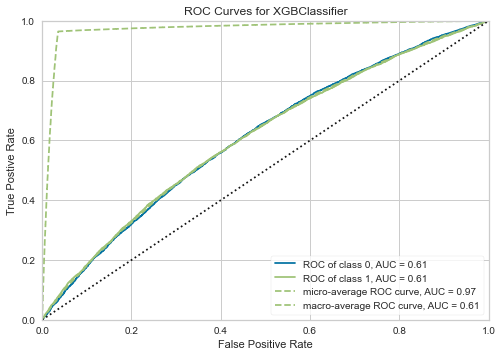

In [17]:
plot_model(xgb)

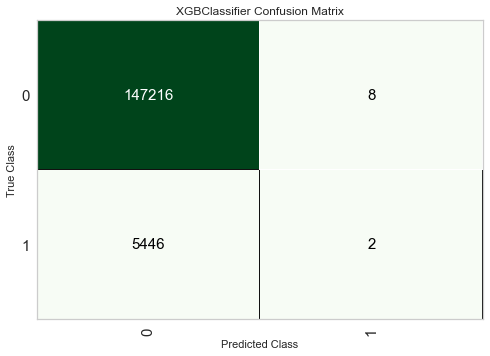

In [18]:
plot_model(xgb, plot = 'confusion_matrix')

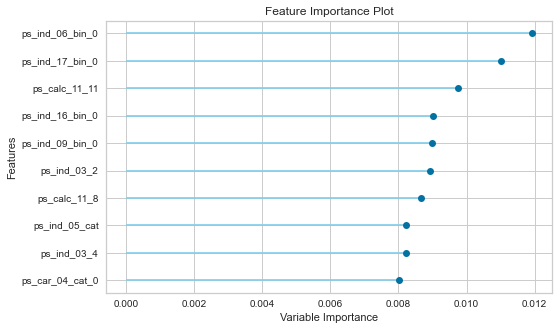

In [19]:
plot_model(xgb, plot = 'feature')

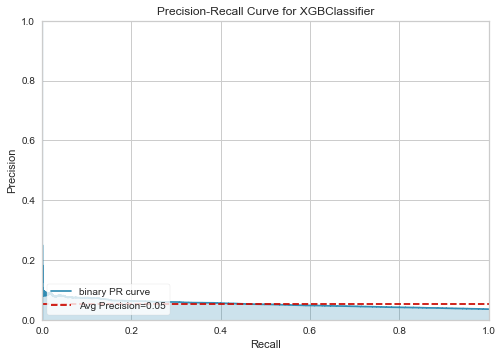

In [20]:
plot_model(xgb, plot = 'pr')

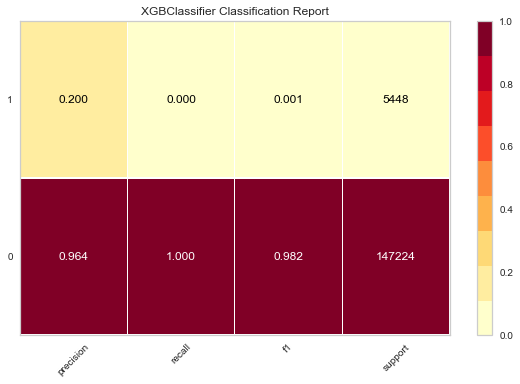

In [21]:
plot_model(xgb, plot = 'class_report')

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0), plot=summary, feature=None, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:model type detected: type 2
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


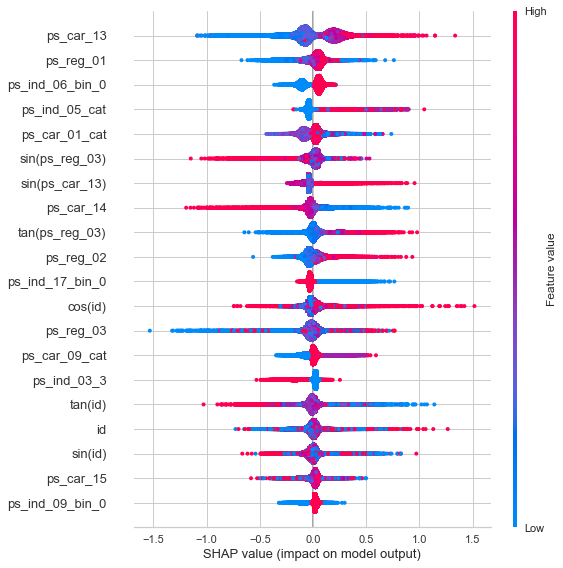

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [24]:
interpret_model(xgb)

In [25]:
pred_holdouts = predict_model(xgb)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9643,0.6096,0.0004,0.2,0.0007,0.0006,0.0072


,id,ps_ind_02_cat,ps_ind_05_cat,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_09_cat,ps_car_11_cat,ps_car_11,...,ps_calc_17_bin_1,ps_calc_18_bin_0,ps_calc_18_bin_1,ps_calc_19_bin_0,ps_calc_19_bin_1,ps_calc_20_bin_0,ps_calc_20_bin_1,target,Label,Score
0,-1.009640,-0.542399,-0.30873,1.004750,2.129341,1.863985e+00,1.078421,0.684457,-1.369656,-0.415740,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0.0330
1,0.550099,-0.542399,-0.30873,1.004750,-0.839017,-1.131843e+00,-0.518111,-1.364072,0.054050,0.785475,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0.0262
2,0.954945,-0.542399,-0.30873,0.657096,1.139888,1.537922e+00,1.078421,0.684457,1.265715,0.785475,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0.1134
3,0.178403,0.965653,-0.30873,-0.385866,-0.591654,-1.303179e+00,-0.917244,0.684457,1.114257,-0.415740,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0.0364
4,1.704331,-0.542399,-0.30873,-1.081174,-1.086380,-2.450736e-14,1.078421,0.684457,-1.824030,0.785475,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0.0526


In [76]:
xgb_final = finalize_model(xgb)

INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
INFO:logs:finalize_model() succesfully completed......................................


In [77]:
save_model(xgb, model_name='xgb')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0), model_name=xgb, verbose=True)
INFO:logs:Appending prep pipeline
INFO:logs:xgb.pkl saved in current working directory
INFO:logs:[Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todr

Transformation Pipeline and Model Succesfully Saved


### Submit Scores

In [13]:
xgb_loaded = load_model('xgb')

Transformation Pipeline and Model Sucessfully Loaded


In [14]:
from sklearn import set_config
set_config(display='diagram')
xgb_loaded[0]

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='classification',
                                      target='target')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    target='target')),
                ('ordinal', Empty()), ('cardinality', Empty...
                ('P_transform', Empty()), ('pt_target', Empty()),
                ('binn', Empty()),
                ('rem_outliers',
                 Outlier(contamination=0.05, methods=['pca'], random_state=123,
                         target='target')),
                ('cluster_all', Empty()), ('dummy', Dummify(target='target')),
                ('fix_perfect', Empty()), ('clean_names', Clean_Colum_Names()),
                ('feature_select', Empty()), ('fix_multi', Empty()),
                ('dfs', Empty()), ('pca', Empty())])

In [16]:
predict_new = predict_model(xgb_loaded, data=df_test_og)

In [19]:
submission = pd.DataFrame({
    "id": df_test_og['id'], 
    "target": predict_new['Score']
    })
submission.to_csv('xgb_pycaret.csv', index=False)

In [21]:
! kaggle competitions submit -c porto-seguro-safe-driver-prediction -f xgb_pycaret.csv -m "xgboost with pycaret_2"

Successfully submitted to Porto Seguro’s Safe Driver Prediction



  0%|          | 0.00/12.9M [00:00<?, ?B/s]
  1%|          | 80.0k/12.9M [00:00<00:20, 657kB/s]
  3%|3         | 456k/12.9M [00:00<00:14, 875kB/s] 
  7%|7         | 960k/12.9M [00:00<00:10, 1.16MB/s]
 11%|#1        | 1.45M/12.9M [00:00<00:07, 1.52MB/s]
 14%|#3        | 1.77M/12.9M [00:00<00:07, 1.50MB/s]
 16%|#5        | 2.04M/12.9M [00:01<00:09, 1.18MB/s]
 17%|#7        | 2.25M/12.9M [00:01<00:08, 1.34MB/s]
 19%|#9        | 2.45M/12.9M [00:01<00:07, 1.47MB/s]
 21%|##        | 2.66M/12.9M [00:01<00:12, 868kB/s] 
 23%|##3       | 2.97M/12.9M [00:01<00:09, 1.11MB/s]
 25%|##5       | 3.26M/12.9M [00:01<00:07, 1.36MB/s]
 27%|##6       | 3.48M/12.9M [00:02<00:09, 1.07MB/s]
 29%|##9       | 3.76M/12.9M [00:02<00:07, 1.32MB/s]
 31%|###       | 3.96M/12.9M [00:02<00:08, 1.10MB/s]
 33%|###2      | 4.20M/12.9M [00:02<00:06, 1.31MB/s]
 34%|###3      | 4.38M/12.9M [00:02<00:07, 1.21MB/s]
 35%|###5      | 4.55M/12.9M [00:03<00:12, 727kB/s] 
 36%|###6      | 4.67M/12.9M [00:03<00:10, 833kB/s]
 38%|